# Exploratory data analysis on raw dataset

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import geopandas as gpd
import utils.constants as c

In [24]:
df_complete_dataset = pd.read_csv(
    "../data/raw/complete_dataset.csv", index_col="datetime", parse_dates=["datetime"]
)
df_station_metadata = pd.read_csv(
    "../data/raw/station_metadata.csv", index_col="id", dtype={"id": str}
)

## Basic information of dataset

In [25]:
df_complete_dataset.describe()

,air_pressure_00183,air_pressure_00591,air_pressure_01694,air_pressure_01759,air_pressure_01975,air_pressure_02115,air_pressure_02429,air_pressure_02907,air_pressure_03032,air_pressure_03093,...,wind_speed_03897,wind_speed_04039,wind_speed_04271,wind_speed_04393,wind_speed_04466,wind_speed_04625,wind_speed_04642,wind_speed_05516,wind_speed_05930,wind_speed_06163
count,817744.000000,818674.000000,818158.000000,815982.000000,819181.000000,814379.000000,815635.000000,818618.000000,817457.000000,801901.000000,...,815887.000000,803251.000000,817084.000000,818168.000000,818200.000000,797872.000000,819060.000000,817660.000000,816844.000000,811586.000000
mean,1009.350159,1009.490045,1007.664507,1013.159593,1013.087017,1013.626736,1011.568335,1013.112796,1010.410410,1013.144098,...,4.432004,3.119373,4.738171,6.343929,3.825129,3.756588,3.500830,6.203449,5.304792,3.681220
std,9.892839,9.614130,9.538528,9.742767,9.821442,10.420947,9.999255,10.374892,10.586486,9.417981,...,2.430850,1.877903,2.746129,3.262552,1.924837,1.966775,1.930115,3.254160,2.865427,2.115723
min,963.300000,962.500000,960.000000,966.800000,968.100000,949.500000,966.500000,967.500000,964.200000,963.200000,...,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1003.400000,1003.700000,1001.900000,1007.300000,1007.200000,1007.400000,1005.600000,1006.900000,1004.100000,1007.500000,...,2.600000,1.700000,2.800000,3.900000,2.400000,2.300000,2.100000,3.700000,3.200000,2.100000
50%,1009.900000,1010.100000,1008.200000,1013.700000,1013.700000,1014.400000,1012.200000,1013.800000,1011.200000,1013.600000,...,4.000000,2.900000,4.100000,5.800000,3.500000,3.400000,3.200000,5.700000,4.800000,3.400000
75%,1015.900000,1015.700000,1013.800000,1019.500000,1019.400000,1020.500000,1018.100000,1019.900000,1017.400000,1019.200000,...,5.800000,4.300000,6.000000,8.300000,4.900000,4.800000,4.600000,8.200000,6.900000,4.900000
max,1043.500000,1042.200000,1040.100000,1046.500000,1046.200000,1048.200000,1045.300000,1048.500000,1046.200000,1045.500000,...,20.200000,17.600000,26.800000,32.800000,20.800000,18.400000,18.800000,27.600000,27.200000,19.000000


In [26]:
df_complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 819674 entries, 2008-06-01 00:00:00 to 2023-12-31 00:00:00
Columns: 120 entries, air_pressure_00183 to wind_speed_06163
dtypes: float64(120)
memory usage: 756.7 MB


## Missing values

Count missing total missing values

In [27]:
total_number_of_values = df_complete_dataset.size
total_number_of_missing_values = df_complete_dataset.isna().sum().sum()
percentage_of_missing_values = (
    total_number_of_missing_values / total_number_of_values
) * 100

print(f"Total number of values: {total_number_of_values}")
print(f"Total number of missing values: {total_number_of_missing_values}")
print(f"Percentage of missing values: {percentage_of_missing_values}")

Total number of values: 98360880
Total number of missing values: 1415425
Percentage of missing values: 1.4390121357189973


Count missing values per column

In [28]:
number_of_missing_values_per_column = df_complete_dataset.isna().sum()
percentage_of_missing_values_per_column = (
    number_of_missing_values_per_column / len(df_complete_dataset)
) * 100

missing_values_per_column_stats = pd.DataFrame(
    {
        "Missing Count": number_of_missing_values_per_column,
        "Missing Percent": percentage_of_missing_values_per_column,
    }
)

print("Missing values for each column (10 columns with the highest ratio of missing values):")
print(missing_values_per_column_stats.sort_values(by="Missing Percent", ascending=False)[:10])

Missing values for each column (10 columns with the highest ratio of missing values):
                      Missing Count  Missing Percent
dew_point_02115               64983         7.927908
wind_speed_02115              63156         7.705014
wind_direction_02115          63089         7.696840
dew_point_04393               59462         7.254347
dew_point_05516               59432         7.250687
dew_point_04271               59289         7.233242
dew_point_01975               58492         7.136008
dew_point_04642               57950         7.069884
dew_point_04466               57301         6.990706
dew_point_02429               53683         6.549311


Count missing values per station

In [ ]:
missing_values_per_station_stats = {}

for col in df_complete_dataset.columns:
    station_id = col.split("_")[-1]
    missing_values_per_station_stats.setdefault(
        station_id, {"Missing Count": 0, "Missing Percent": 0}
    )

    num_missing_values = df_complete_dataset[col].isna().sum()
    missing_values_per_station_stats[station_id][
        "Missing Count"
    ] += num_missing_values

number_of_columns_per_station = len(missing_values_per_station_stats)
number_of_values_per_station = total_number_of_values / number_of_columns_per_station

for station_id in missing_values_per_station_stats.keys():
    num_missing_values = missing_values_per_station_stats[station_id][
        "Missing Count"
    ]
    missing_values_per_station_stats[station_id]["Missing Percent"] = (
        num_missing_values / number_of_values_per_station
    ) * 100

missing_values_per_station_stats_df = pd.DataFrame(
    missing_values_per_station_stats
).transpose()

print("Missing values for each station:")
print(
    missing_values_per_station_stats_df.sort_values(
        by="Missing Percent", ascending=False
    )
)

Missing values for each station:
       Missing Count  Missing Percent
02115       209751.0         4.264927
03093       150568.0         3.061542
02429       114284.0         2.323769
04625        96583.0         1.963850
03032        82141.0         1.670197
04393        69005.0         1.403098
04271        68913.0         1.401228
05516        66695.0         1.356129
01975        64944.0         1.320525
04466        63857.0         1.298423
04642        59887.0         1.217700
06163        58197.0         1.183336
01759        56461.0         1.148038
04039        44101.0         0.896718
03897        43473.0         0.883949
00183        38666.0         0.786207
05930        35541.0         0.722665
01694        33192.0         0.674902
02907        32679.0         0.664471
00591        26487.0         0.538568


Check missing values for the reference station

In [48]:
print("Missing Values for reference station:")
print(
    missing_values_per_column_stats.loc[
        missing_values_per_column_stats.index.str.contains("03897")
    ]
)

eval_test_period = df_complete_dataset.loc["2019-08-27":, f"wind_speed_{c.REFERENCE_STATION_ID}"]
num_nas = eval_test_period.isna().sum()
print(f"Number of NaNs for target wind speed in eval and test period: {num_nas}")
print(f"Percentage of NaNs for target wind speed in eval and test period: {(num_nas / len(eval_test_period)) * 100}")

Missing Values for reference station:
                         Missing Count  Missing Percent
air_pressure_03897                3477         0.424193
air_temperature_03897             2649         0.323177
dew_point_03897                  26243         3.201639
relative_humidity_03897           3663         0.446885
wind_direction_03897              3654         0.445787
wind_speed_03897                  3787         0.462013
Number of NaNs for target wind speed in eval and test period: 2448
Percentage of NaNs for target wind speed in eval and test period: 1.0711988412849136


Check for skipped timestamps


In [31]:
expected_freq = pd.date_range(
    start=df_complete_dataset.index.min(),
    end=df_complete_dataset.index.max(),
    freq="10min",
)
missing_timestamps = expected_freq.difference(df_complete_dataset.index)
print(f"Number of missing timestamps: {len(missing_timestamps)}")

Number of missing timestamps: 0


## Explore reference station

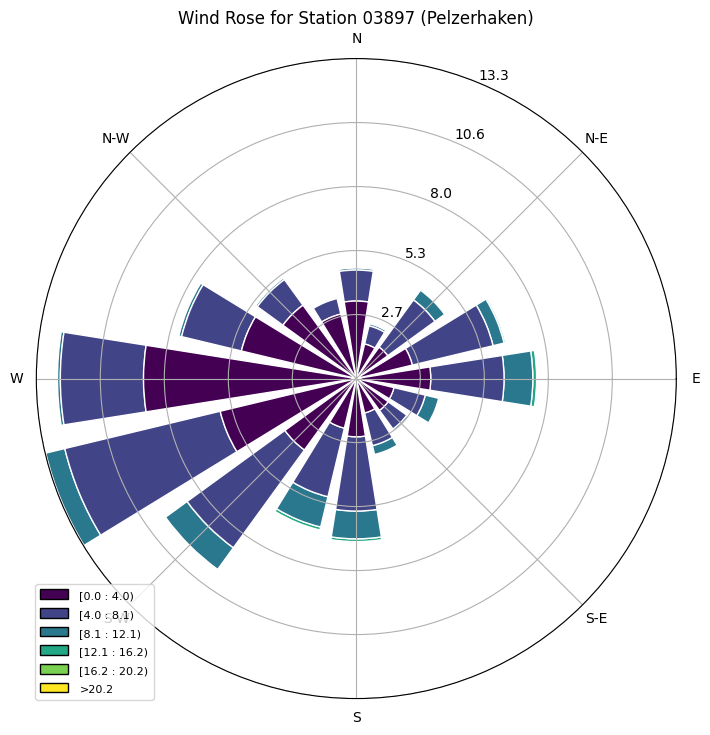

In [32]:

reference_wind_direction_column = f"wind_direction_{c.REFERENCE_STATION_ID}"
reference_wind_speed_column = f"wind_speed_{c.REFERENCE_STATION_ID}"

df_reference_wind = df_complete_dataset[
    [reference_wind_direction_column, reference_wind_speed_column]
].dropna()

station_name = df_station_metadata.loc[c.REFERENCE_STATION_ID, "name"]

wind_rose_fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=wind_rose_fig)
ax.bar(
    df_reference_wind[reference_wind_direction_column],
    df_reference_wind[reference_wind_speed_column],
    normed=True,
    opening=0.8,
    edgecolor="white",
)

ax.set_legend()

plt.title(f"Wind Rose for Station {c.REFERENCE_STATION_ID} ({station_name})")
plt.show()

## Visualize station locations

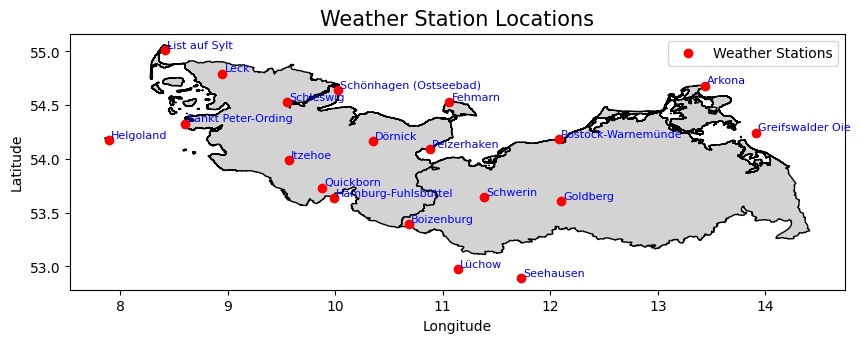

In [33]:
gdf_stations = gpd.GeoDataFrame(
    df_station_metadata,
    geometry=gpd.GeoSeries.from_xy(
        df_station_metadata.geographic_longitude,
        df_station_metadata.geographic_latitude,
    ),
)

germany = gpd.read_file("shape_files/gadm41_DEU_shp/gadm41_DEU_1.shp")
schleswig_holstein = germany[germany.NAME_1 == "Schleswig-Holstein"]
meck_pom = germany[germany.NAME_1 == "Mecklenburg-Vorpommern"]

fig, ax = plt.subplots(figsize=(10, 10))

schleswig_holstein.plot(ax=ax, color="lightgray", edgecolor="black")
meck_pom.plot(ax=ax, color="lightgray", edgecolor="black")

gdf_stations.plot(ax=ax, color="red", marker="o", label="Weather Stations")

for x, y, label in zip(
    gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations["name"]
):
    ax.text(x + 0.02, y + 0.02, label, fontsize=8, ha="left", color="blue")

ax.set_title("Weather Station Locations", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.legend()

plt.show()